In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
df1 = pd.read_csv('application_train.csv')
df1.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df2 = pd.read_csv('bureau.csv')
df2.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [4]:
merge1 = df2.merge(df1[['SK_ID_CURR','TARGET']], on='SK_ID_CURR')

# number of credit records
print(merge1[['SK_ID_CURR','CREDIT_ACTIVE']][merge1['TARGET'] == 1].groupby('SK_ID_CURR').count().mean())
print(merge1[['SK_ID_CURR','CREDIT_ACTIVE']][merge1['TARGET'] == 0].groupby('SK_ID_CURR').count().mean())

print(merge1[['SK_ID_CURR','CREDIT_ACTIVE']][(merge1['TARGET'] == 1) & (merge1['CREDIT_ACTIVE']=='Active')].groupby('SK_ID_CURR').count().mean())
print(merge1[['SK_ID_CURR','CREDIT_ACTIVE']][(merge1['TARGET'] == 0) & (merge1['CREDIT_ACTIVE']=='Active')].groupby('SK_ID_CURR').count().mean())

# days between current and most recent credit application
print(merge1[['SK_ID_CURR','DAYS_CREDIT']][(merge1['TARGET'] == 1)].groupby('SK_ID_CURR').max().mean())
print(merge1[['SK_ID_CURR','DAYS_CREDIT']][(merge1['TARGET'] == 0)].groupby('SK_ID_CURR').max().mean())

# type of credits
print(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 1].groupby('CREDIT_TYPE').count()/len(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 1]))
print(round(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 0].groupby('CREDIT_TYPE').count()/len(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 0]),6))


CREDIT_ACTIVE    5.622545
dtype: float64
CREDIT_ACTIVE    5.556056
dtype: float64
CREDIT_ACTIVE    2.83631
dtype: float64
CREDIT_ACTIVE    2.465274
dtype: float64
DAYS_CREDIT   -396.838816
dtype: float64
DAYS_CREDIT   -497.04371
dtype: float64
                                        SK_ID_CURR
CREDIT_TYPE                                       
Another type of loan                      0.000533
Car loan                                  0.011561
Cash loan (non-earmarked)                 0.000009
Consumer credit                           0.698970
Credit card                               0.264251
Loan for business development             0.000926
Loan for the purchase of equipment        0.000035
Loan for working capital replenishment    0.000419
Microloan                                 0.016233
Mortgage                                  0.006811
Unknown type of loan                      0.000253
                                              SK_ID_CURR
CREDIT_TYPE                         

Text(0.5, 1.0, 'Average records of previous Credit Bureau credits')

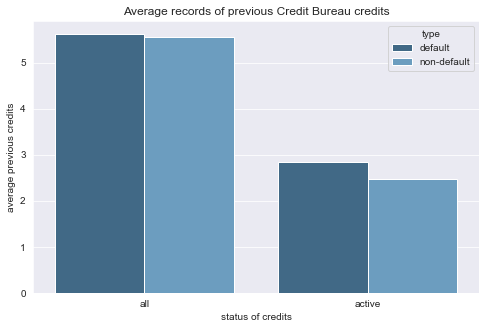

In [5]:
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
data1 = pd.DataFrame({'type':['default','default','non-default','non-default'],
                    'average previous credits':[5.622545,2.83631,5.556056,2.465274],
                    'status of credits':['all','active','all','active']})

ax = sns.barplot(x="status of credits", y="average previous credits", hue="type", data=data1,palette="Blues_d")
plt.title('Average records of previous Credit Bureau credits')

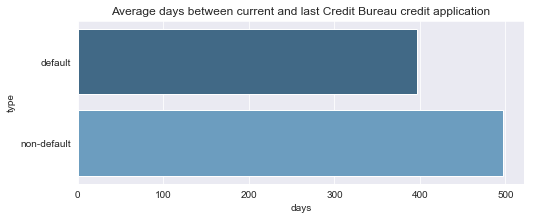

In [6]:
plt.figure(figsize=(8,3))
sns.set_style("darkgrid")
plt.title('Average days between current and last Credit Bureau credit application')
data1_1 = pd.DataFrame({'type':['default','non-default'],
                    'days':[396.838816,497.04371]})

ax = sns.barplot(y="type", x="days",data=data1_1,palette="Blues_d")

Text(0.5, 1.0, 'Type of Previous Credit Bureau credit')

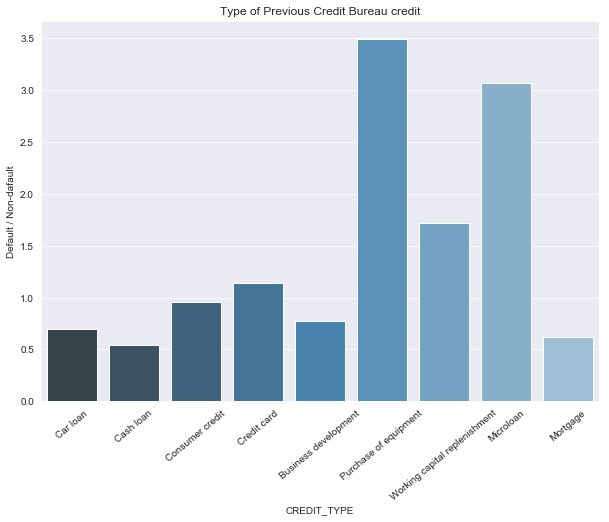

In [7]:
df1_1 = merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 1].groupby('CREDIT_TYPE').count()/len(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 1])
df1_1 = df1_1.reset_index()
df1_2 = round(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 0].groupby('CREDIT_TYPE').count()/len(merge1[['SK_ID_CURR','CREDIT_TYPE']][merge1['TARGET'] == 0]),6)
df1_2 = df1_2.reset_index()
merge1_1 = pd.merge(df1_1, df1_2, on='CREDIT_TYPE', suffixes=['_default', '_non-default'])
merge1_1['Default / Non-dafault'] = merge1_1['SK_ID_CURR_default']/merge1_1['SK_ID_CURR_non-default']
merge1_1 = merge1_1.replace({'CREDIT_TYPE':'Cash loan (non-earmarked)'}, 'Cash loan')
merge1_1 = merge1_1.replace({'CREDIT_TYPE':'Loan for business development'}, 'Business development')
merge1_1 = merge1_1.replace({'CREDIT_TYPE':'Loan for the purchase of equipment'}, 'Purchase of equipment')
merge1_1 = merge1_1.replace({'CREDIT_TYPE':'Loan for working capital replenishment'}, 'Working capital replenishment')

plt.figure(figsize=(10,7))
sns.set_style("darkgrid")
ax = sns.barplot(x="CREDIT_TYPE", y="Default / Non-dafault", data=merge1_1.loc[1:9],palette="Blues_d")

for item in ax.get_xticklabels():
    item.set_rotation(40)
plt.title('Type of Previous Credit Bureau credit')

In [8]:
df3 = pd.read_csv('bureau_balance.csv')
df3.head(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


In [9]:
merge2 = df3.merge(df2,on='SK_ID_BUREAU').merge(df1[['SK_ID_CURR','TARGET']], on='SK_ID_CURR')
print(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 1) & (merge2['MONTHS_BALANCE'] == -1)].groupby('STATUS').count()/len(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 1) & (merge2['MONTHS_BALANCE'] == -1)]))
print(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 0) & (merge2['MONTHS_BALANCE'] == -1)].groupby('STATUS').count()/len(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 0) & (merge2['MONTHS_BALANCE'] == -1)]))

        SK_ID_CURR
STATUS            
0         0.320654
1         0.018672
2         0.001490
3         0.000381
4         0.000416
5         0.003083
C         0.480461
X         0.174842
        SK_ID_CURR
STATUS            
0         0.266127
1         0.009802
2         0.000585
3         0.000243
4         0.000159
5         0.002219
C         0.550753
X         0.170112


Text(0.5, 1.0, 'Status of Most Recent Credit Bureau loan')

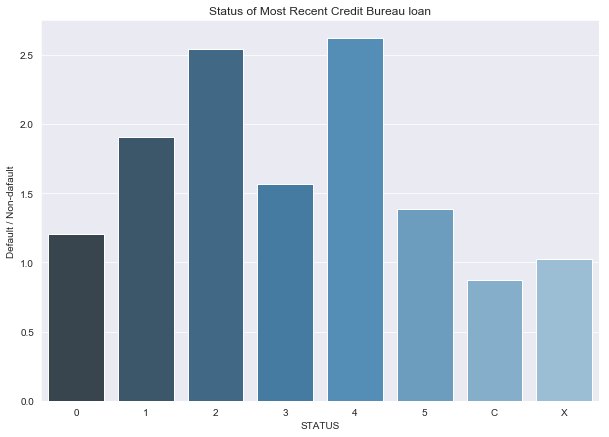

In [10]:
merge2 = df3.merge(df2,on='SK_ID_BUREAU').merge(df1[['SK_ID_CURR','TARGET']], on='SK_ID_CURR')
df2_1 = merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 1) & (merge2['MONTHS_BALANCE'] == -1)].groupby('STATUS').count()/len(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 1) & (merge2['MONTHS_BALANCE'] == -1)])
df2_1 = df2_1.reset_index()
df2_2 = merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 0) & (merge2['MONTHS_BALANCE'] == -1)].groupby('STATUS').count()/len(merge2[['SK_ID_CURR','STATUS']][(merge2['TARGET'] == 0) & (merge2['MONTHS_BALANCE'] == -1)])
df2_2 = df2_2.reset_index()
merge2_1 = pd.merge(df2_1, df2_2, on='STATUS', suffixes=['_default', '_non-default'])
merge2_1['Default / Non-dafault'] = merge2_1['SK_ID_CURR_default']/merge2_1['SK_ID_CURR_non-default']

plt.figure(figsize=(10,7))
sns.set_style("darkgrid")
ax = sns.barplot(x="STATUS", y="Default / Non-dafault", data=merge2_1,palette="Blues_d")
plt.title('Status of Most Recent Credit Bureau loan')

# C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30,
# 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off 

In [11]:
df4 = pd.read_csv('POS_CASH_balance.csv')
df4.head(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [12]:
merge3 = df4.merge(df1[['SK_ID_CURR','TARGET']],on='SK_ID_CURR')

print(merge3[['CNT_INSTALMENT']][(merge3['TARGET'] == 1) & (merge3['MONTHS_BALANCE'] == -1)].mean())
print(merge3[['CNT_INSTALMENT']][(merge3['TARGET'] == 0) & (merge3['MONTHS_BALANCE'] == -1)].mean())

print(merge3[['CNT_INSTALMENT_FUTURE']][(merge3['TARGET'] == 1) & (merge3['MONTHS_BALANCE'] == -1)].mean())
print(merge3[['CNT_INSTALMENT_FUTURE']][(merge3['TARGET'] == 0) & (merge3['MONTHS_BALANCE'] == -1)].mean())

CNT_INSTALMENT    24.40787
dtype: float64
CNT_INSTALMENT    22.464601
dtype: float64
CNT_INSTALMENT_FUTURE    14.187227
dtype: float64
CNT_INSTALMENT_FUTURE    11.980522
dtype: float64


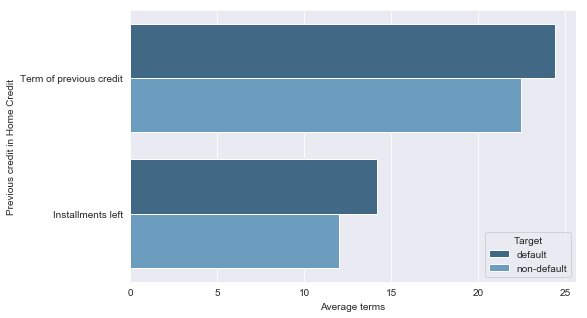

In [13]:
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
data3 = pd.DataFrame({'Target':['default','default','non-default','non-default'],
                    'Average terms':[24.40787,14.187227,22.464601,11.980522],
                    'Previous credit in Home Credit':['Term of previous credit','Installments left','Term of previous credit','Installments left']})

ax = sns.barplot(y="Previous credit in Home Credit", x="Average terms", hue="Target", data=data3,palette="Blues_d")

In [14]:
df5 = pd.read_csv('credit_card_balance.csv')
df5.head(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


Text(0.5, 1.0, 'Average Credit Card Balance Before Application Date')

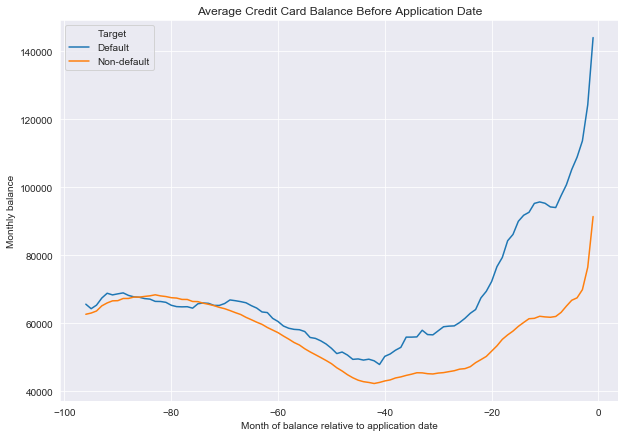

In [15]:
merge4 = df5.merge(df1[['SK_ID_CURR','TARGET']],on='SK_ID_CURR')

df4_1 = merge4[['MONTHS_BALANCE','AMT_BALANCE']][merge4['TARGET']==1].groupby('MONTHS_BALANCE').sum()/merge4[['MONTHS_BALANCE','AMT_BALANCE']][merge4['TARGET']==1].groupby('MONTHS_BALANCE').count()
df4_1 = df4_1.reset_index()
df4_2 = merge4[['MONTHS_BALANCE','AMT_BALANCE']][merge4['TARGET']==0].groupby('MONTHS_BALANCE').sum()/merge4[['MONTHS_BALANCE','AMT_BALANCE']][merge4['TARGET']==0].groupby('MONTHS_BALANCE').count()
df4_2 = df4_2.reset_index()

merge4_1 = df4_1.merge(df4_2,on='MONTHS_BALANCE',suffixes=['_default', '_non-default'])
merge4_1.columns = ['Month of balance relative to application date','Default','Non-default']

plt.figure(figsize=(10,7))
sns.set_style("darkgrid")
ax = sns.lineplot(x='Month of balance relative to application date', y='Monthly balance', hue='Target', 
             data=pd.melt(merge4_1, 
                          id_vars=['Month of balance relative to application date'], 
                          var_name='Target', 
                          value_name='Monthly balance'))
plt.title('Average Credit Card Balance Before Application Date')

In [16]:
df6 = pd.read_csv('previous_application.csv')
df6.head(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [17]:
merge5 = df6.merge(df1[['SK_ID_CURR','TARGET']],on='SK_ID_CURR')
print(merge5[['AMT_APPLICATION']][merge5['TARGET'] == 1].mean())
print(merge5[['AMT_APPLICATION']][merge5['TARGET'] == 0].mean())

print(merge5[['AMT_CREDIT']][merge5['TARGET'] == 1].mean())
print(merge5[['AMT_CREDIT']][merge5['TARGET'] == 0].mean())

merge5['DIFF'] = merge5['AMT_CREDIT'] - merge5['AMT_APPLICATION']
print(merge5[['DIFF']][merge5['TARGET'] == 1].mean())
print(merge5[['DIFF']][merge5['TARGET'] == 0].mean())

AMT_APPLICATION    169918.355998
dtype: float64
AMT_APPLICATION    175748.182419
dtype: float64
AMT_CREDIT    193914.702632
dtype: float64
AMT_CREDIT    196585.226093
dtype: float64
DIFF    23994.957947
dtype: float64
DIFF    20837.043674
dtype: float64


Text(0.5, 1.0, 'Previous Applications for Home Credit loans')

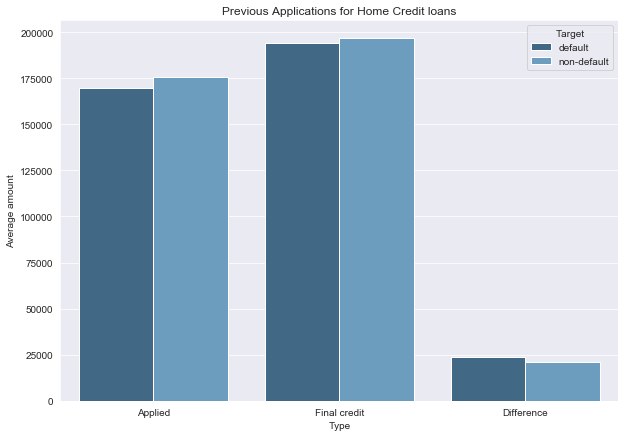

In [18]:
plt.figure(figsize=(10,7))
data5 = pd.DataFrame({'Target':['default','non-default','default','non-default','default','non-default'],
                    'Average amount':[169918.355998,175748.182419,193914.702632,196585.226093,23994.957947,20837.043674],
                    'Type':['Applied','Applied','Final credit','Final credit','Difference','Difference']})

ax = sns.barplot(x="Type", y="Average amount", hue="Target", data=data5,palette="Blues_d")
plt.title('Previous Applications for Home Credit loans')